# 理论知识
## 参考小小将的文章学习扩散模型的数学原理（https://zhuanlan.zhihu.com/p/563661713），回答如下问题：

**1. 请简述 DDPM 的正向过程（Forward Process）和反向过程（Reverse Process）分别在做什么？**

**2.前向过程中，为什么要使用高斯噪声？**

**3. 在前向过程中，给定初始图像和步数 ，我们是否需要一步步计算 才能得到 ？为什么？**

**4. 前向过程中，噪声调度系数是怎么变化的，为什么要这样变化？**

**5. 在推导反向过程时，我们先计算了$q(x_{t-1} | x_t, x_0)$ 这里的条件 $x_0$ 代表什么？为什么说加上这个条件后，分布就变得“可解”了？这与我们最终生成图片时的实际情况有什么矛盾？**

**6. 在反向过程中，去掉一个时间步的噪声是如何实现的**

**7. 可以思考一下为什么预测噪声，而不是预测均值或$x_0$？**

**8. 优化目标的三个项的含义分别是什么**

**9. 优化目标的三个项中，哪一项是最主要的？为什么？**




# 代码部分：
## 以下代码来自于小小将文章中demo

**要求：**

1.将代码每个模块都熟悉，理解其作用，部分模块附有问题，需要给出回答

2.将代码运行，查看效果

3.说明扩散模型的训练流程



## DDPM 

Denoising Diffusion Probabilistic Model with PyTorch implementation

### References
- https://github.com/hojonathanho/diffusion
- https://github.com/lucidrains/denoising-diffusion-pytorch
- https://github.com/openai/improved-diffusion/
- https://arxiv.org/abs/2006.11239
- https://huggingface.co/blog/annotated-diffusion


In [1]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

## ↓关于时间步嵌入：
**1.时间步嵌入是如何实现的？**

**2.为什么要对时间步进行嵌入，他的作用是什么？**


In [2]:
# use sinusoidal position embedding to encode time step (https://arxiv.org/abs/1706.03762)
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [3]:
# define TimestepEmbedSequential to support `time_emb` as extra input
class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

# use GN for norm layer
def norm_layer(channels):
    return nn.GroupNorm(32, channels)

In [4]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)

In [5]:
# Attention block with shortcut
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0
        
        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

In [6]:
# upsample
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

# downsample
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

# 关于UNet：
**1.UNet是如何实现的？**

**2.UNet在扩散模型中的作用是什么？**


In [7]:
# The full UNet model with attention and timestep embedding
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2
        
        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

# 关于方差调度

**1.将这两种方差调度可视化**

**2.观察调度曲线，说明两种调度的区别**



In [8]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

# 关于GaussianDiffusion：

**1. 这个类的作用是什么**

**2.里面有一个_extract方法，请问这个方法的作用是什么**

**3. DDPM相关的参数是怎么计算的**

**3. 前向过程和反向过程对应的实现代码是什么，代码是怎么执行的**




In [9]:
class GaussianDiffusion:
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    
    # denoise: reverse diffusion
    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=device)
        imgs = []
        for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img.cpu().numpy())
        return imgs
    
    # sample new images
    @torch.no_grad()
    def sample(self, model, image_size, batch_size=8, channels=3):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))
    
    # compute train losses
    def train_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

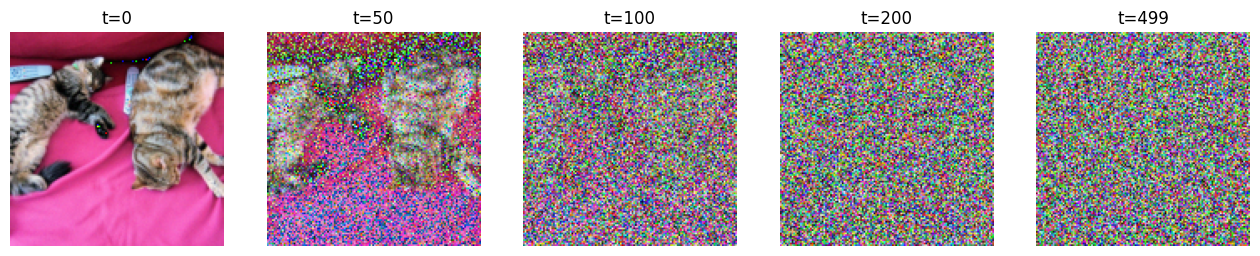

In [12]:
from PIL import Image
import requests
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Load image from URL (this is working)
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# Remove this line - the file doesn't exist locally
# image = Image.open("/data/000000039769.jpg")
image_size = 128
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


x_start = transform(image).unsqueeze(0)

gaussian_diffusion = GaussianDiffusion(timesteps=500)

plt.figure(figsize=(16, 8))
for idx, t in enumerate([0, 50, 100, 200, 499]):
    x_noisy = gaussian_diffusion.q_sample(x_start, t=torch.tensor([t]))
    noisy_image = (x_noisy.squeeze().permute(1, 2, 0) + 1) * 127.5
    noisy_image = noisy_image.numpy().astype(np.uint8)
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")

In [14]:
batch_size = 64
timesteps = 500

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# use MNIST dataset
dataset = datasets.MNIST('/data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# define model and diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[]
)
model.to(device)

gaussian_diffusion = GaussianDiffusion(timesteps=timesteps)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [15]:
# train
epochs = 10

for epoch in range(epochs):
    for step, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        
        if step % 200 == 0:
            print("Loss:", loss.item())
            
        loss.backward()
        optimizer.step()

Loss: 1.16702139377594
Loss: 0.03546487167477608
Loss: 0.02878417633473873
Loss: 0.027215028181672096
Loss: 0.027565721422433853
Loss: 0.020249968394637108
Loss: 0.018929464742541313
Loss: 0.02697654254734516
Loss: 0.03589465469121933
Loss: 0.024241110309958458
Loss: 0.02376614697277546
Loss: 0.02554137073457241
Loss: 0.027623720467090607
Loss: 0.024873727932572365
Loss: 0.026319192722439766
Loss: 0.02372770383954048
Loss: 0.02115475758910179
Loss: 0.023067792877554893
Loss: 0.02426746115088463
Loss: 0.02121593989431858
Loss: 0.021705185994505882
Loss: 0.028424929827451706
Loss: 0.02303456887602806
Loss: 0.027221331372857094
Loss: 0.0205696914345026
Loss: 0.024414898827672005
Loss: 0.025025391951203346
Loss: 0.025776300579309464
Loss: 0.022146044299006462
Loss: 0.018122851848602295
Loss: 0.023076621815562248
Loss: 0.021857749670743942
Loss: 0.032774943858385086
Loss: 0.026793984696269035
Loss: 0.030431373044848442
Loss: 0.022357551380991936
Loss: 0.024092765524983406
Loss: 0.0273170340

In [16]:
generated_images = gaussian_diffusion.sample(model, 28, batch_size=64, channels=1)

sampling loop time step: 100%|██████████| 500/500 [00:26<00:00, 18.72it/s]


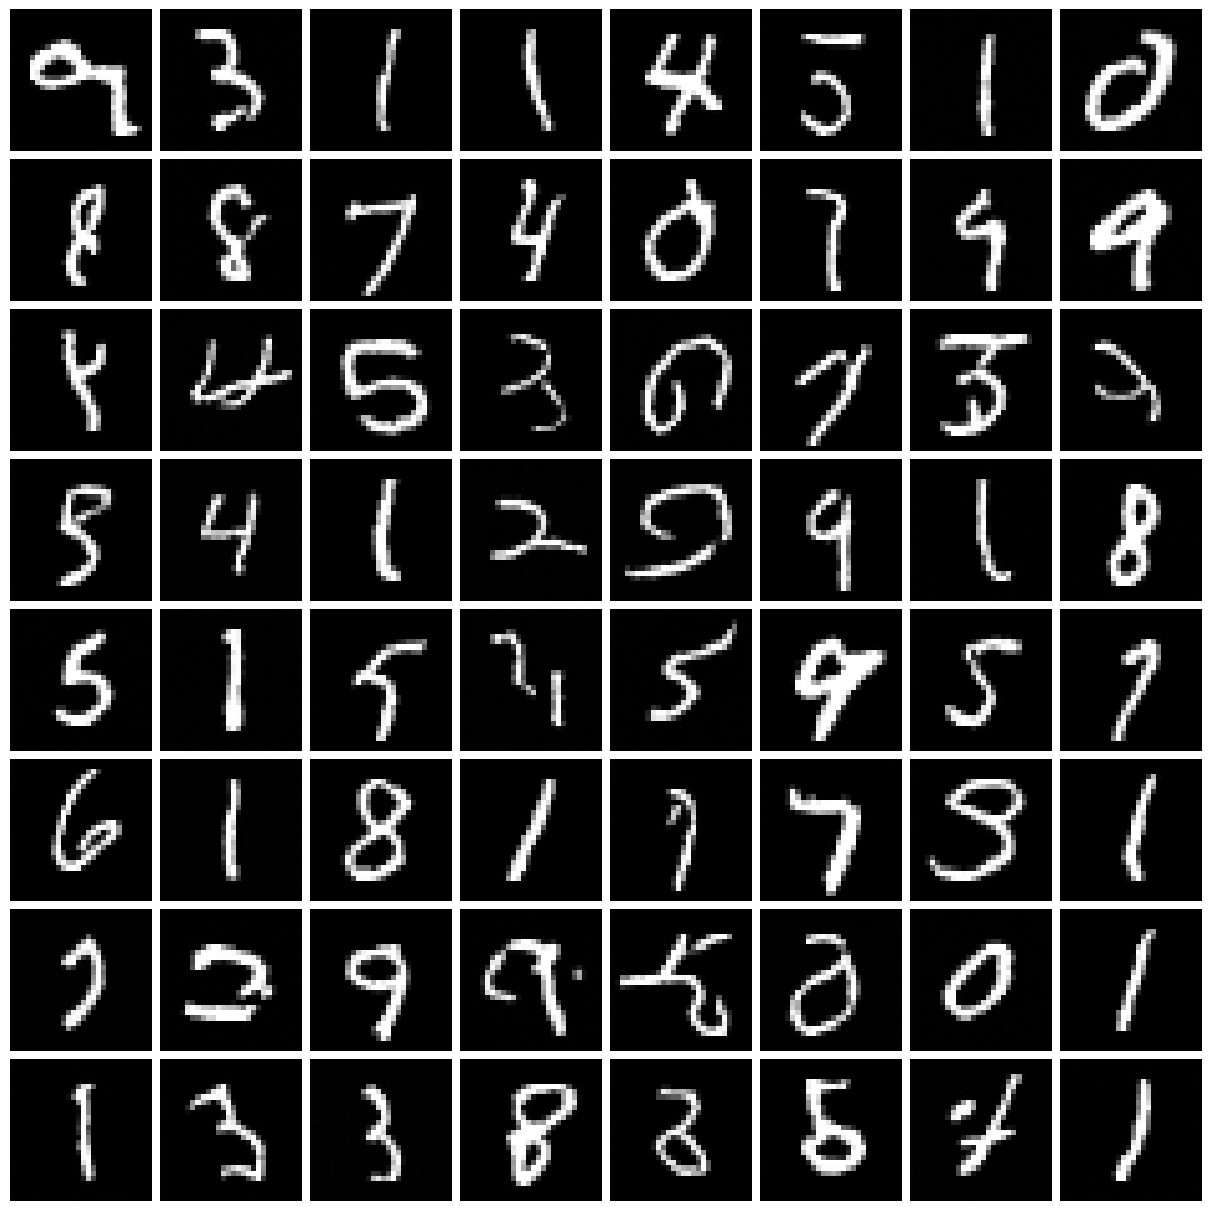

In [17]:
# generate new images
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(8, 8)

imgs = generated_images[-1].reshape(8, 8, 28, 28)
for n_row in range(8):
    for n_col in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")

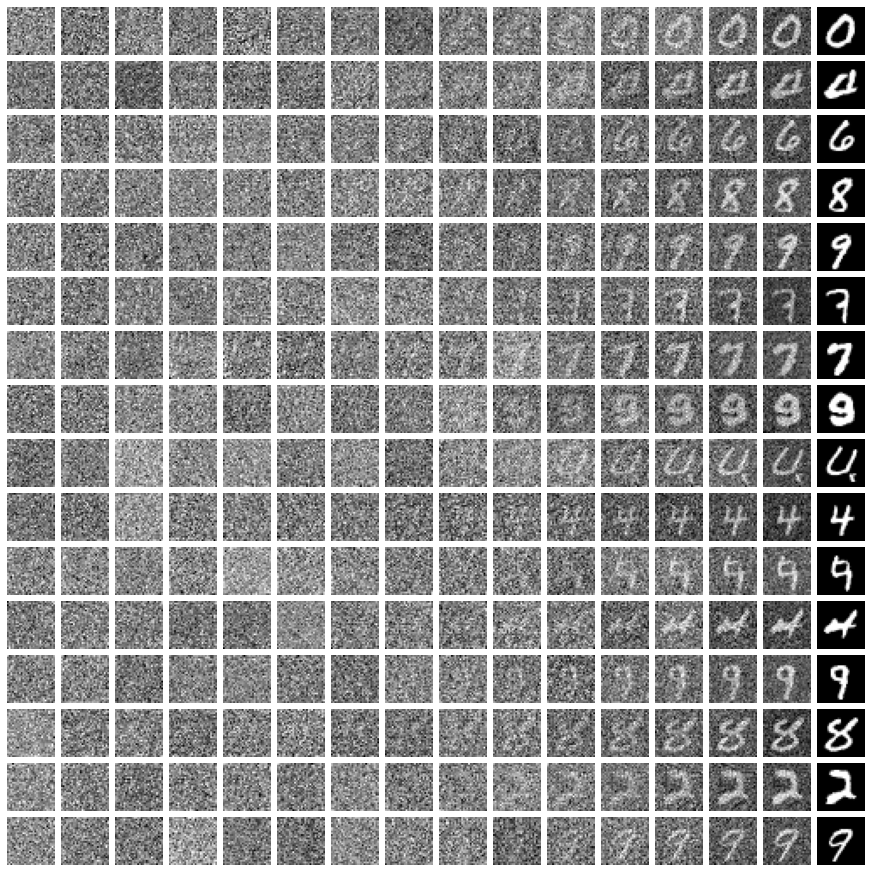

In [ ]:
# show the denoise steps
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(16, 16)

for n_row in range(16):
    for n_col in range(16):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        t_idx = (timesteps // 16) * n_col if n_col < 15 else -1
        img = generated_images[t_idx][n_row].reshape(28, 28)
        f_ax.imshow((img+1.0) * 255 / 2, cmap="gray")
        f_ax.axis("off")